<a href="https://colab.research.google.com/github/dkimds/goormthon/blob/main/Practice/Appendix/9_Transfer_learning_(torchvision_models).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br><br>

<p style="color:red; font-size:1.3em;"> * 본 실습에는 <b>0.13 이상 버전의 torchvision</b> 이 필요합니다.</p><br>
<p style="font-size:1.3em;">* Colab 에서 본 실습 파일을 업로드하고 <span style="color:red;"> <b>GPU 로 런타임을 변경</b></span> 후 실습을 진행해주세요!
    
<br>

<br>
<br>

# * Pretrained models

<hr>
<br>

#### **PyTorch libraries for specific domains** <br><br> - **torchvision**.models @ https://pytorch.org/vision/stable/models.html <br><br> - **torchtext**.models @ https://pytorch.org/text/main/models.html <br><br> - **torchaudio**.models @ https://pytorch.org/audio/stable/models.html <br><br> - **torchrec**.models @ https://pytorch.org/torchrec/torchrec.models.html
<br>

<hr>
<br>

#### **HuggingFace Hub** (vision, text, audio and more) <br><br> - https://huggingface.co/models <br><br> - https://huggingface.co/datasets
<br>

<hr>
<br>

#### **timm** (PyTorch Image Models) library <br><br> - https://github.com/rwightman/pytorch-image-models <br><br> - https://rwightman.github.io/pytorch-image-models/ <br><br> - Getting Started with PyTorch Image Models (timm): A Practitioner’s Guide @ https://bit.ly/3F1kD8H
<br>

<hr>
<br>

#### **Papers-with-code**  <br><br> - https://paperswithcode.com/
<br>

<hr>
<br>

<br>
<br>

# 0. Import libraries

In [1]:
from IPython.display import clear_output # Cell 내의 출력을 자동으로 지워주는 함수

!pip install torchvision
!pip install torchinfo
!pip install torchmetrics

clear_output() # clear the output after the installation

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__) # 0.13 이상 버전의 torchvision 이 필요합니다

import torchinfo
import torchmetrics

print(torchinfo.__version__)    # 1.7.1
print(torchmetrics.__version__) # 0.11.0

2.3.0+cu121
0.18.0+cu121
1.8.0
1.4.0.post0


In [3]:
!nvidia-smi

# Check the status of the nvidia GPU

Tue Jul  9 04:20:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

from torch.utils.data import DataLoader # class for loading the dataset (Dataset -> Batches)
from torchmetrics import Accuracy
from torchinfo import summary # summarize the model structure

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder # Load "Image" data from selected "Folder"s

import zipfile
import os
import glob
import random

from PIL import Image
from tqdm.auto import tqdm # We will use the tqdm
from timeit import default_timer as timer

<br>
<br>

# 1. Prepare the dataset
<br>

### * Original Dataset : **Food-101** @ https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

<br>

- **101** food categories<br>
- **101,000** images<br>
- **750** training images & **250** test images per class<br>
- rescaled to have a **maximum side length of 512 pixels**

<hr>

#### * 구글드라이브에 접속한 후 [ **data_food101** ] 폴더를 만들고 [ **Food101.zip** ] 파일과 [ **sample_pizza.jpg** ] 파일을 업로드해줍니다.

<hr>

In [5]:
from google.colab import drive

drive.mount('/gdrive') # Mount the google-drive

Mounted at /gdrive


In [6]:
data_path = '/gdrive/MyDrive/data_food101/'

for info in os.walk(data_path): # 거닐다
    print(info)

('/gdrive/MyDrive/data_food101/', [], ['Food101.zip', 'sample_pizza.jpg'])


In [7]:
with zipfile.ZipFile(data_path + "Food101.zip", "r") as zip_f:

    print("Unzipping the dataset.")

    zip_f.extractall(data_path + "data") # "extract" "all" files

Unzipping the dataset.


In [8]:
for dir_path, dir_names, file_names in os.walk(data_path + "data"):

    if len(dir_names) == 3:
        print('--------------------------------')

    print("There are {} directories and {} images in '{}'.".format(len(dir_names), len(file_names), dir_path))

There are 2 directories and 0 images in '/gdrive/MyDrive/data_food101/data'.
--------------------------------
There are 3 directories and 0 images in '/gdrive/MyDrive/data_food101/data/test'.
There are 0 directories and 25 images in '/gdrive/MyDrive/data_food101/data/test/pizza'.
There are 0 directories and 19 images in '/gdrive/MyDrive/data_food101/data/test/steak'.
There are 0 directories and 31 images in '/gdrive/MyDrive/data_food101/data/test/sushi'.
--------------------------------
There are 3 directories and 0 images in '/gdrive/MyDrive/data_food101/data/train'.
There are 0 directories and 78 images in '/gdrive/MyDrive/data_food101/data/train/pizza'.
There are 0 directories and 75 images in '/gdrive/MyDrive/data_food101/data/train/steak'.
There are 0 directories and 72 images in '/gdrive/MyDrive/data_food101/data/train/sushi'.


In [9]:
TRAIN_DIR = "/gdrive/MyDrive/data_food101/data/train"
TEST_DIR  = "/gdrive/MyDrive/data_food101/data/test"

<br>
<br>

# 2. Prepare the **DataLoader**

### 1) Get the **transforms** that were used to train the pre-trained model

In [10]:
# torchvision.models @ https://pytorch.org/vision/stable/models.html

for name in dir(torchvision.models): # pre-trained "models" in torchvision
    if ("Weight" not in name) and ("__" not in name) and (not name.startswith('_')):
        print(name)

AlexNet
ConvNeXt
DenseNet
EfficientNet
GoogLeNet
GoogLeNetOutputs
Inception3
InceptionOutputs
MNASNet
MaxVit
MobileNetV2
MobileNetV3
RegNet
ResNet
ShuffleNetV2
SqueezeNet
SwinTransformer
VGG
VisionTransformer
alexnet
convnext
convnext_base
convnext_large
convnext_small
convnext_tiny
densenet
densenet121
densenet161
densenet169
densenet201
detection
efficientnet
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
get_model
get_model_builder
get_model_weights
get_weight
googlenet
inception
inception_v3
list_models
maxvit
maxvit_t
mnasnet
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mobilenetv2
mobilenetv3
optical_flow
quantization
regnet
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_128gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet

In [11]:
for name in dir(torchvision.models):
    if "Weight" in name:
        print(name)

AlexNet_Weights
ConvNeXt_Base_Weights
ConvNeXt_Large_Weights
ConvNeXt_Small_Weights
ConvNeXt_Tiny_Weights
DenseNet121_Weights
DenseNet161_Weights
DenseNet169_Weights
DenseNet201_Weights
EfficientNet_B0_Weights
EfficientNet_B1_Weights
EfficientNet_B2_Weights
EfficientNet_B3_Weights
EfficientNet_B4_Weights
EfficientNet_B5_Weights
EfficientNet_B6_Weights
EfficientNet_B7_Weights
EfficientNet_V2_L_Weights
EfficientNet_V2_M_Weights
EfficientNet_V2_S_Weights
GoogLeNet_Weights
Inception_V3_Weights
MNASNet0_5_Weights
MNASNet0_75_Weights
MNASNet1_0_Weights
MNASNet1_3_Weights
MaxVit_T_Weights
MobileNet_V2_Weights
MobileNet_V3_Large_Weights
MobileNet_V3_Small_Weights
RegNet_X_16GF_Weights
RegNet_X_1_6GF_Weights
RegNet_X_32GF_Weights
RegNet_X_3_2GF_Weights
RegNet_X_400MF_Weights
RegNet_X_800MF_Weights
RegNet_X_8GF_Weights
RegNet_Y_128GF_Weights
RegNet_Y_16GF_Weights
RegNet_Y_1_6GF_Weights
RegNet_Y_32GF_Weights
RegNet_Y_3_2GF_Weights
RegNet_Y_400MF_Weights
RegNet_Y_800MF_Weights
RegNet_Y_8GF_Weights

In [12]:
# Pre-trained weights (EfficientNet_B0 on ImageNet)

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# B0의 "0"와 같은 숫자가 커질수록 성능이 좋으나 동시에 모델 크기가 커짐
# .DEFAULT = best available weights on ImageNet (vs .IMAGENET1K_V1, .IMAGENET1K_V2)

weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [14]:
# The transforms that were used to train the "EfficientNet_B0_Weights" on "ImageNet"

transform_efficientNet = weights.transforms() # "transforms" that were used to train "weights"

transform_efficientNet # mean & std 는 채널별로 normalize를 적용할 때 활용된 값

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

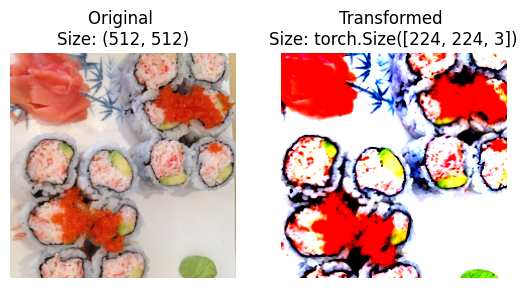

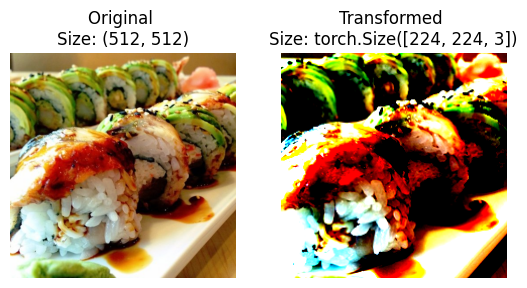

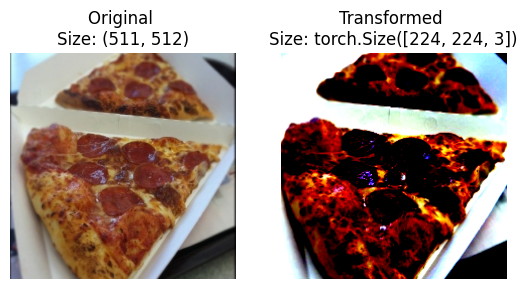

In [16]:
train_images = glob.glob(TRAIN_DIR + "/*/*.jpg")

random_img_3 = random.sample(train_images, k=3) # sampling

for rand_img in random_img_3:
    with Image.open(rand_img) as img:

        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(img)
        ax[0].set_title("Original \nSize: {}".format(img.size)) # show the "size" of an image
        ax[0].axis("off")

        # PyTorch's    default image shape == [ Channels, Height, Width ]
        # Matplotlib's default image shape == [ Height, Width, Channels ]
        img_transformed = transform_efficientNet(img).permute(1, 2, 0) # permutation

        ax[1].imshow(img_transformed)
        ax[1].set_title("Transformed \nSize: {}".format(img_transformed.shape))
        ax[1].axis("off")

### 2) Prepare the **DataLoader** with the loaded transforms

In [24]:
# Load "Image" data from selected "Folder"s

train_imgfolder = ImageFolder(root=TRAIN_DIR,
                              transform=transform_efficientNet) # The transforms that were used to train the "EfficientNet_B0_Weights" on "ImageNet"

test_imgfolder  = ImageFolder(root=TEST_DIR,
                              transform=transform_efficientNet) # Augmentation이 적용되어있지 않으므로 test set에도 동일하게 활용 가능

In [25]:
class_names = train_imgfolder.classes

print(class_names)

['pizza', 'steak', 'sushi']


In [26]:
# class for loading the dataset (Dataset -> Batches)

torch.manual_seed(42)

train_dataloader = DataLoader(dataset=train_imgfolder,
                              batch_size=32,
                              num_workers=os.cpu_count(), # number of subprocesses to use for data loading
                              shuffle=True,
                              pin_memory=True)

test_dataloader  = DataLoader(dataset=test_imgfolder,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=False,
                              pin_memory=True)

<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.float32


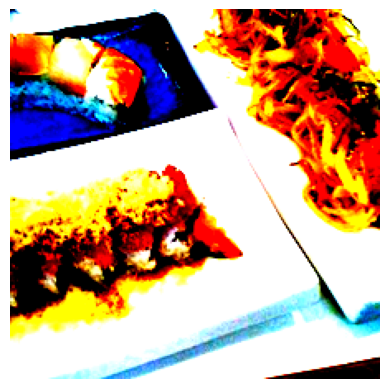

In [27]:
batch_x, batch_y = next(iter(train_dataloader))

image_sample = batch_x[0]

print(type(image_sample))
print(image_sample.shape) # after the data-augmentation
print(image_sample.dtype)

plt.imshow(image_sample.permute(1, 2, 0)) # permutation
plt.axis("off")
plt.show()

<br>
<br>

# 3. Build the model with **pre-trained models**

#### * **EfficientNet** : Rethinking Model Scaling for Convolutional Neural Networks @ https://arxiv.org/abs/1905.11946

### 1) Load the pre-trained model

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu" # "cuda"가 사용 가능하다면 (if it "is available")

device

'cuda'

In [29]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights).to(device) # torchvision v0.13+
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # old version ("pretrained=True")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 121MB/s] 


In [30]:
summary(model=model, input_size=(32, 3, 224, 224)) # from torchinfo import summary

# default out_features=1000 (ImageNet : 1000 classes)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [31]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        # depth=10, # check what happens with this change
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 2) Freeze the parameters within [ feature-extractor ]

In [32]:
# "features"라는 이름을 가진 layer 그룹의 parameter들을 Non-trainable로 변경 vs model.parameters()
# (위 summary 결과 중 "Sequential (features)"의 "features"에 해당)

for param in model.features.parameters():

    param.requires_grad = False # "requires" "grad"ient-descent

In [33]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        # depth=10, # check what happens with this change
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 3) Change the [ classifier ] for our dataset

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_classes = len(class_names) # 3

In [35]:
# "classifier"라는 이름을 가진 layer 그룹을 덮어씀
# (위 summary 결과 중 "Sequential (classifier)"의 "classifier"에 해당)

model.classifier = torch.nn.Sequential( # Sequential model
    nn.Dropout(0.2, inplace=True), # Apply the drop-out
    nn.Linear(in_features=1280, # == 1280 * 1 * 1
              out_features=num_classes)
).to(device)

In [36]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        # depth=10, # check what happens with this change
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

<br>
<br>

# 4. Train the model

### 1) Make train & test step as separate functions



In [37]:
def train_step(model, dataloader, loss_fn, optimizer, metric, device):

    # 모델을 training mode로 설정 (default state)
    model.train()

    # train-loss & train-accuracy for one epoch
    train_loss = 0
    train_acc  = 0

    for batch_idx, (X, y) in enumerate(dataloader): # X & y == a single batch

        X = X.to(device)
        y = y.to(device)

        # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        logits = model(X)

        # 2. (Batch) Training cost 계산 (Cost function 계산)
        loss = loss_fn(logits, y) # cost of batch <- nn.CrossEntropyLoss() : built-in Softmax
        train_loss += loss.item()

        # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
        optimizer.zero_grad()

        # 4. Back-propagation ("Backward" propagation)
        loss.backward()

        # 5. Gradient descent 진행 (Take a "step" to update parameters)
        optimizer.step()

        # 6. (Batch) Training accuracy 계산
        predicted_classes = logits.softmax(dim=1).argmax(dim=1)
        train_acc += metric(predicted_classes, y).item() # calculate the batch accuracy & add to the epoch accuracy


    # Batch 순회 종료 후
    train_loss = train_loss / len(dataloader) # cost of batches / num of batches (calculate average)
    train_acc  = train_acc  / len(dataloader) # acc  of batches / num of batches (calculate average)

    return train_loss, train_acc

In [38]:
def test_step(model, dataloader, loss_fn, metric, device):

    # 모델을 evaluation mode로 설정
    model.eval()

    # test-loss & test-accuracy for one epoch
    test_loss = 0
    test_acc  = 0

    with torch.inference_mode(): # Set "inference mode"

        for batch_idx, (X, y) in enumerate(dataloader): # X & y == a single batch

            X = X.to(device)
            y = y.to(device)

            # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
            logits = model(X)

            # 2. (Batch) Test cost 계산 (Cost function 계산)
            loss = loss_fn(logits, y) # cost of batch <- nn.CrossEntropyLoss() : built-in Softmax
            test_loss += loss.item()

            # 3. (Batch) Test accuracy 계산
            predicted_classes = logits.softmax(dim=1).argmax(dim=1)
            test_acc += metric(predicted_classes, y).item() # calculate the batch accuracy & add to the epoch accuracy


    # Batch 순회 종료 후
    test_loss = test_loss / len(dataloader) # cost of batches / num of batches (calculate average)
    test_acc  = test_acc  / len(dataloader) # acc  of batches / num of batches (calculate average)

    return test_loss, test_acc

<br>

### 2) Combine train & test step into a simplified "train" function

In [39]:
def train(model,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn,
          metric,
          device,
          epochs):


    results = {"train_loss": [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc"  : []}


    for epoch in tqdm(range(epochs)): # from tqdm.auto import tqdm

        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           metric=metric,
                                           device=device)

        test_loss, test_acc   = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          metric=metric,
                                          device=device)


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        print('Epoch : {} | Train_loss : {} | Train_acc : {} | Test_loss : {} | Test_acc : {}'.format(epoch+1,
                                                                                                      train_loss,
                                                                                                      train_acc,
                                                                                                      test_loss,
                                                                                                      test_acc))

    return results

<br>

### 3) Train the model & Check the result

In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [41]:
loss_fn = nn.CrossEntropyLoss() # Softmax + CrossEntropy (built-in Softmax)

optimizer = torch.optim.Adam(params=model.parameters(), # "parameters" to optimize (apply gradient descent)
                             lr=0.001)                  # "l"earning "r"ate

metric_accuracy = Accuracy(task="multiclass", num_classes=len(class_names)).to(device) # from torchmetrics import Accuracy

In [42]:
START_TIME = timer() # from timeit import default_timer as timer

NUM_EPOCHS = 30

model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      metric=metric_accuracy,
                      device=device,
                      epochs=30)

END_TIME = timer()

print('Training time : {} seconds'.format(round(END_TIME-START_TIME, 2)))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch : 1 | Train_loss : 1.0924270376563072 | Train_acc : 0.3984375 | Test_loss : 0.9132681488990784 | Test_acc : 0.5397727290789286
Epoch : 2 | Train_loss : 0.8716965243220329 | Train_acc : 0.77734375 | Test_loss : 0.791197657585144 | Test_acc : 0.8153409163157145
Epoch : 3 | Train_loss : 0.7647949755191803 | Train_acc : 0.79296875 | Test_loss : 0.7463406125704447 | Test_acc : 0.8560606042544047
Epoch : 4 | Train_loss : 0.7108824998140335 | Train_acc : 0.75390625 | Test_loss : 0.6373109022776285 | Test_acc : 0.8655303120613098
Epoch : 5 | Train_loss : 0.6254764012992382 | Train_acc : 0.78515625 | Test_loss : 0.6261006593704224 | Test_acc : 0.8560606042544047
Epoch : 6 | Train_loss : 0.5784515738487244 | Train_acc : 0.89453125 | Test_loss : 0.5743227005004883 | Test_acc : 0.8759469787279764
Epoch : 7 | Train_loss : 0.5262740328907967 | Train_acc : 0.91015625 | Test_loss : 0.5469824473063151 | Test_acc : 0.8759469787279764
Epoch : 8 | Train_loss : 0.5226370729506016 | Train_acc : 0.8007

In [ ]:
# model_results

In [43]:
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [45]:
train_loss = model_results['train_loss']
test_loss  = model_results['test_loss']

train_acc  = model_results['train_acc']
test_acc   = model_results['test_acc']

epochs = range(len(model_results['train_loss']))

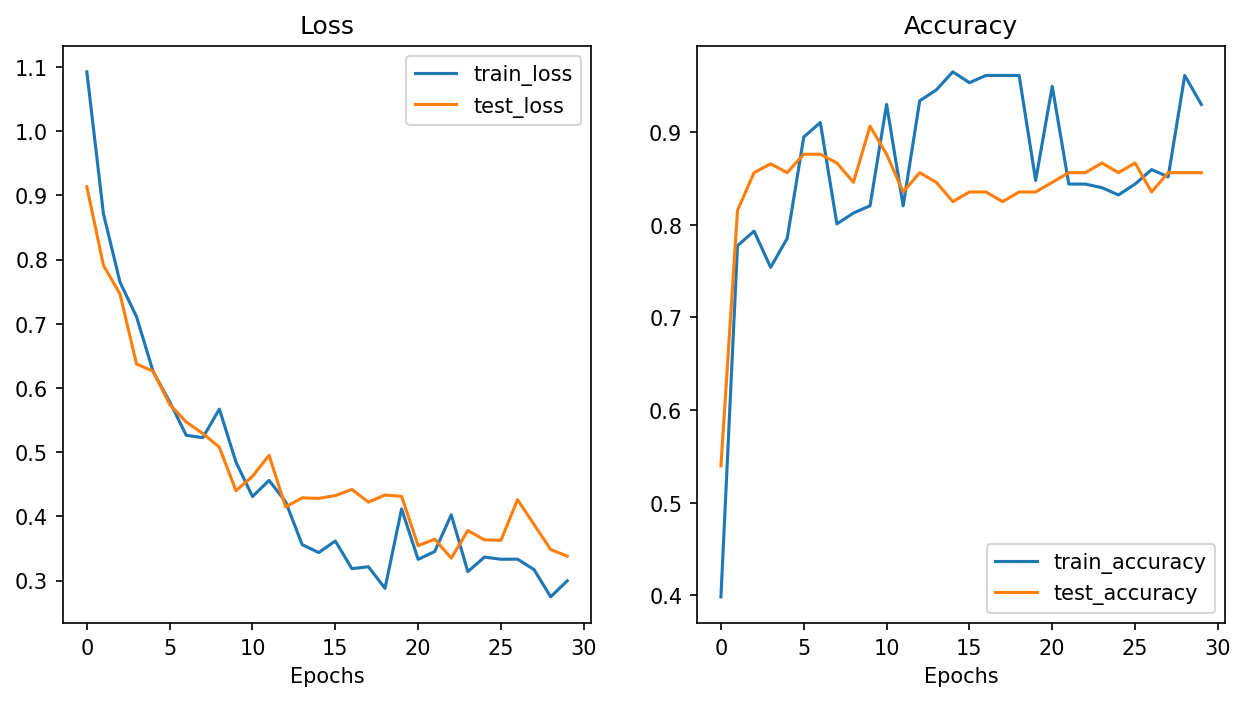

In [47]:
plt.figure(figsize=(10, 5), dpi=150)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='train_loss')
plt.plot(epochs, test_loss,  label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='train_accuracy')
plt.plot(epochs, test_acc,  label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

<br>
<br>

# (Appendix 1) Predict on a new image

In [48]:
def predict_img(model, image_path, class_names, transform, device):

    img = Image.open(image_path) # from PIL import Image

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize((224, 224)), # ImageNet
            transforms.ToTensor(), # [ value / 255.0 ] & type-casting to torch.tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
      ])

    img_tensor = image_transform(img).to(device)
    img_tensor = img_tensor.unsqueeze(dim=0) # [Channels, Height, Width] -> [Batch_size, Channels, Height, Width]


    model.to(device)
    model.eval()

    with torch.inference_mode():
        img_logits = model(img_tensor)


    predicted_prob = img_logits.softmax(dim=1).max(dim=1)[0].item()
    predicted_class = img_logits.softmax(dim=1).argmax(dim=1)
    predicted_class_name = class_names[predicted_class]


    plt.figure(figsize=(5, 5), dpi=100)
    plt.imshow(img)

    title = "Pred: {} | Prob: {:.2f}%".format(predicted_class_name, predicted_prob * 100)
    plt.title(title)
    plt.axis(False)
    plt.show()

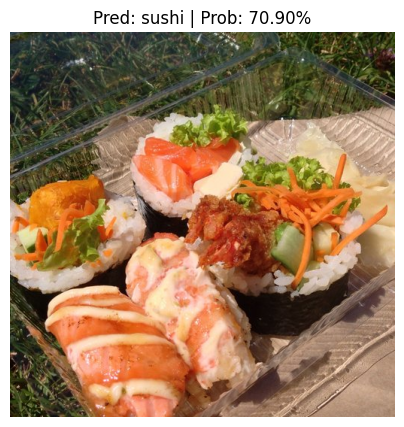

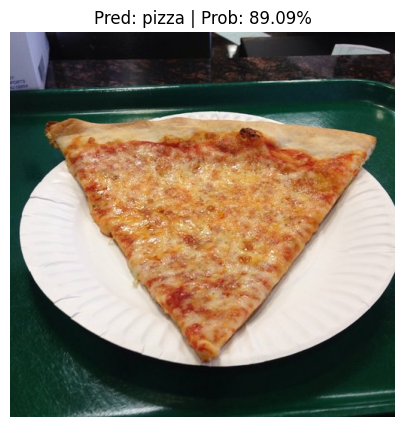

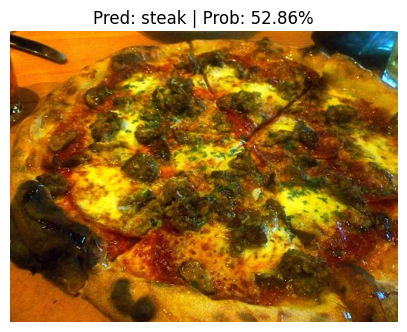

In [50]:
test_images = glob.glob(TEST_DIR + "/*/*.jpg")
random_img_3 = random.sample(test_images, k=3) # sampling

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights on ImageNet
transform_efficientNet = weights.transforms() # "transforms" that were used to train "weights"


for image_path in random_img_3:

    predict_img(model=model,
                image_path=image_path,
                class_names=class_names,
                transform=transform_efficientNet,
                device=device)

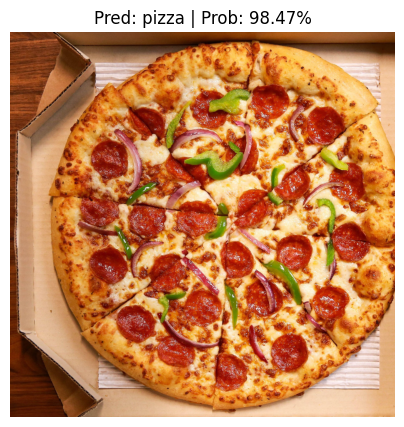

In [51]:
predict_img(model=model,
            image_path='/gdrive/MyDrive/data_food101/' + 'sample_pizza.jpg',
            class_names=class_names,
            transform=transform_efficientNet,
            device=device)

<br>
<br>

# (Appendix 2) Save & Load the model

### 1) **Save**


#### 모델을 통째로 저장하고 불러오는 것도 가능 @ https://pytorch.org/tutorials/beginner/saving_loading_models.html

#### -> **torch.save(model, PATH)** & **model = torch.load(PATH)**

In [52]:
torch.save(obj=model.state_dict(), # only parameters
           f='/gdrive/MyDrive/data_food101/' + 'EfficientNet_v1.pth')

<br>
<br>

### 2) **Load**

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
torch.cuda.manual_seed(42)


weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights on ImageNet
model_loaded = torchvision.models.efficientnet_b0(weights=weights)
model_loaded = model_loaded.to(device)

# Sequential (features)
for param in model_loaded.features.parameters():
    param.requires_grad = False # "requires" "grad"ient-descent

# Sequential (classifier)
model_loaded.classifier = torch.nn.Sequential(
    nn.Dropout(0.2, inplace=True), # Apply the drop-out
    nn.Linear(in_features=1280, # == 1280 * 1 * 1
              out_features=3)
)


model_loaded.load_state_dict(torch.load(f='/gdrive/MyDrive/data_food101' + '/EfficientNet_v1.pth')) # load -> load_state_dict
model_loaded = model_loaded.to(device)

In [55]:
loss_test = 0
acc_test  = 0


# 1. 모델을 evaluation mode로 설정
model_loaded.eval()

# 2. inference mode 세팅
with torch.inference_mode():

    # 3. Batch-data 준비
    for X, y in test_dataloader:

        X = X.to(device)
        y = y.to(device)

        # 4. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        y_pred = model(X)

        # 5. Test cost 계산
        loss_test += loss_fn(y_pred, y) # cost of batch
        acc_test  += metric_accuracy(y_pred.argmax(dim=1), y) # Softmax 적용 여부는 argmax 결과에 영향을 미치지 않음

    # Calculate the average loss/acc per batch
    loss_test_avg = loss_test / len(test_dataloader)
    acc_test_avg  = acc_test  / len(test_dataloader)


model_result_loaded = {"model_name": model_loaded.__class__.__name__,
                       "model_loss": loss_test_avg.item(),
                       "model_acc": acc_test_avg.item()}

model_result_loaded

{'model_name': 'EfficientNet',
 'model_loss': 0.3380393385887146,
 'model_acc': 0.8560606241226196}

In [56]:
from google.colab import files

files.download('/gdrive/MyDrive/data_food101/' + 'EfficientNet_v1.pth') # download a file from the file's path

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>